In [2]:
import matplotlib.pyplot as plt
import numpy as np
import glob
import cv2
import gc
import pickle
import tensorflow
import pandas as pd
from tensorflow import keras
from skimage.color import rgb2gray
from skimage.measure import label 
from scipy.ndimage import binary_opening, binary_closing, rotate
from scipy.ndimage.morphology import binary_fill_holes
from sklearn.model_selection import train_test_split

In [4]:
def mask_image(im):
    '''This function returns the proper binary form of the taken input image'''

    # Remove the most intensive pixels as they refer to the skull
    mask = (im != 1)
    
    # Apply the mask to the image
    im_masked = np.where(mask, im, 0)
    
    # Remove unwanted parts around the brain
    mask_brain = binary_opening(im_masked, structure=np.ones((13,13))).astype(int)
    
    # Fill the blanks in the binary image and return it
    return binary_fill_holes(mask_brain)

In [5]:
def brain_component(mask):
    '''This function returns the biggest component of the binary image'''
    
    # Label the binary image
    labels = label(mask)
    
    # Return the biggest component of labeled binary image
    return labels == np.argmax(np.bincount(labels.flat, weights=mask.flat))

In [6]:
def crop_image(im, mask):
    '''This function takes an image and its mask, returns the image which is cropped according to the mask frames'''
    
    # Find the indices of white spaces in the binary image
    indices = np.where(mask == 1)
    
    # Create a list of zip objects of x and y indices
    indices_zipped = list(zip(indices[0], indices[1]))
    
    # Find the up-most and down-most pixels
    x_min = list(indices_zipped[0])
    x_max = list(indices_zipped[-1])
    
    # Sort the zip objects according to their y index values
    indices_zipped_sort = sorted(indices_zipped, key = lambda x: x[1])
    
    # Find the right-most and left-most pixels
    y_min = list(indices_zipped_sort[0])
    y_max = list(indices_zipped_sort[-1])
    
    # Apply the mask to the image
    im_masked = np.where(mask, im, 0)
    
    # Crop the image by slicing and return it
    im_cropped = im_masked[x_min[0]:x_max[0], y_min[1]:y_max[1]]
    return im_cropped

In [7]:
def plot_images(array):
    '''This function plots the first ten instances of the given input list of images'''
    
    # Create subplots and display the first ten instance in them
    fig, ax = plt.subplots(1,10, figsize=(50, 50))
    i = 0
    for im in array[:10]:
        ax[i].imshow(im, cmap='gray')
        i = i + 1
    plt.show()

In [8]:
def image_process(data, label):
    '''This function applies all the preprocessing functions to the given input and returns them as labeled'''
    
    # Perform gray-scale transformation
    data_gray_scaled = list(map(lambda im: rgb2gray(im), data))
    
    # PLot gray-scaled images
    plot_images(data_gray_scaled)
    
    # Apply the mask_image function
    data_masks = list(map(lambda im: mask_image(im), data_gray_scaled))
    
    # Plot masks 
    plot_images(data_masks)
    
    # Apply the brain_component function
    data_brains = list(map(lambda mask: brain_component(mask), data_masks))
    
    # Plot brain components
    plot_images(data_brains)
    
    # Apply the crop_image function
    data_brains_cropped = [crop_image(data_gray_scaled[i], data_brains[i]) for i in range(0, len(data_brains))]
    
    # Plot images
    plot_images(data_brains_cropped)
    
    # Resize images to the shape of (255, 255)
    data_resized = [cv2.resize(i, (225,225), interpolation=cv2.INTER_AREA) for i in data_brains_cropped]
    
    # Reduce the noise via blurring
    data_set = [cv2.GaussianBlur(i, (3, 3), cv2.BORDER_DEFAULT) for i in  data_resized]
    
    # Label the images
    data_set_labeled = [[i, label] for i in data_set]

    return data_set_labeled

In [22]:
def plot_loss_accuracy(history):
    historydf = pd.DataFrame(history.history, index=history.epoch)
    plt.figure(figsize=(8, 6))
    historydf.plot(ylim=(0, max(1, historydf.values.max())))
    loss = history.history['loss'][-1]
    acc = history.history['accuracy'][-1]
    plt.title('Loss: %.3f, Accuracy: %.3f' % (loss, acc))

In [9]:
inmeyok_images = [cv2.imread(file) for file in glob.glob("INMEYOK/PNG/*.png")]
iskemi_images = [cv2.imread(file) for file in glob.glob("ISKEMI/PNG/*.png")]
kanama_images = [cv2.imread(file) for file in glob.glob("KANAMA/PNG/*.png")]

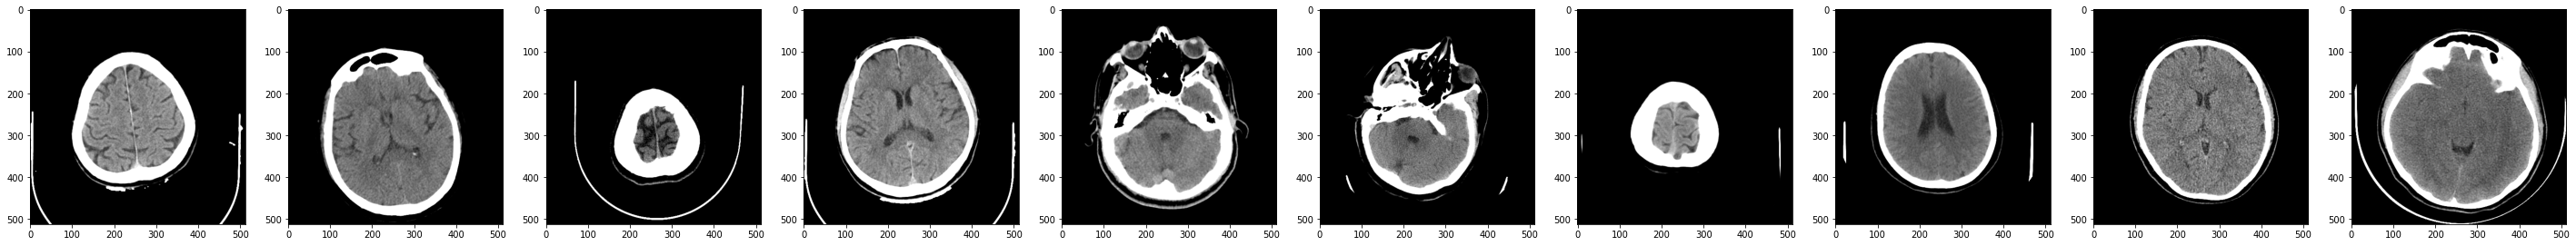

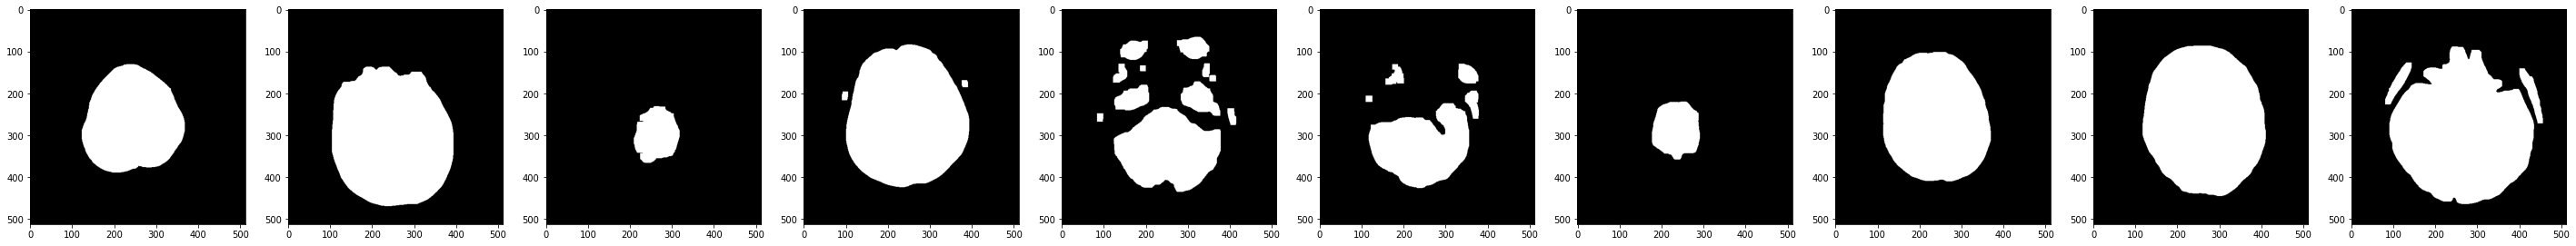

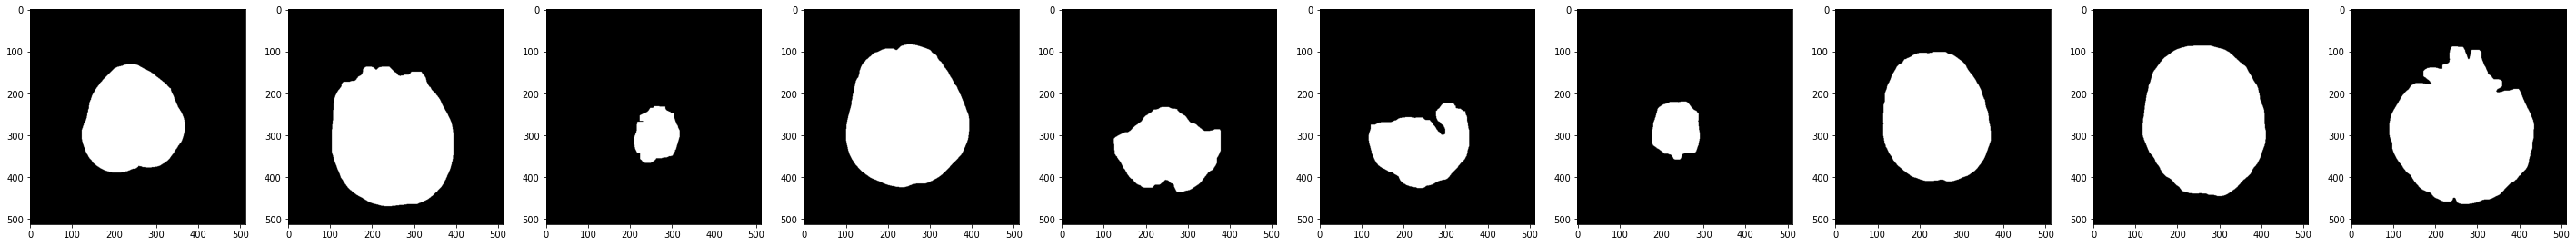

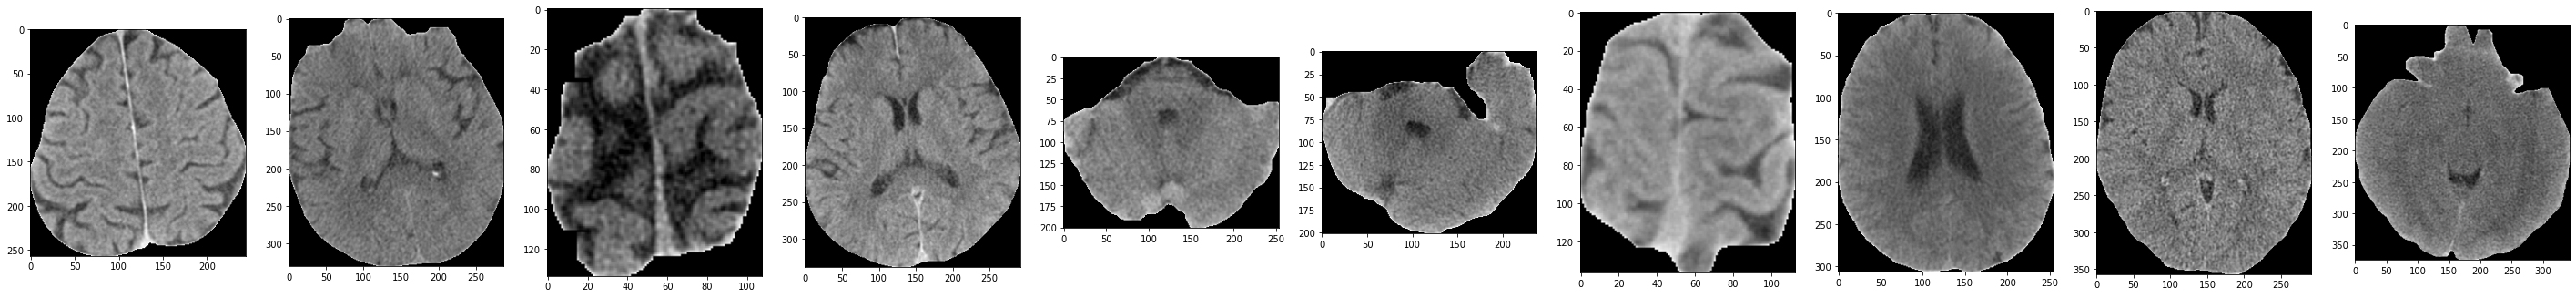

In [10]:
inmeyok_set_labeled = image_process(inmeyok_images, 0)

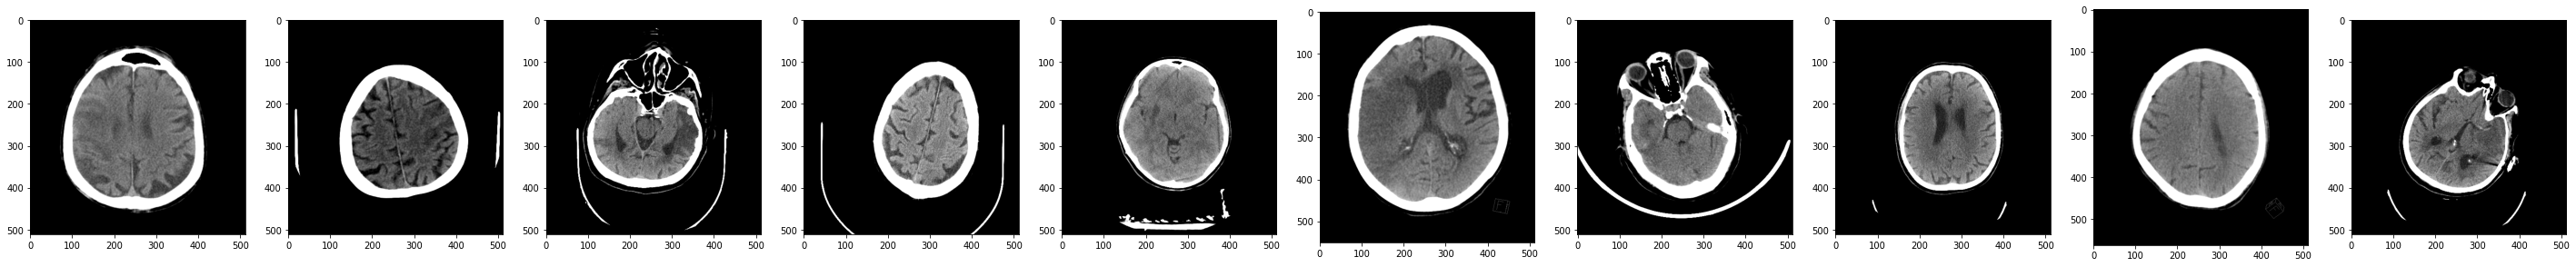

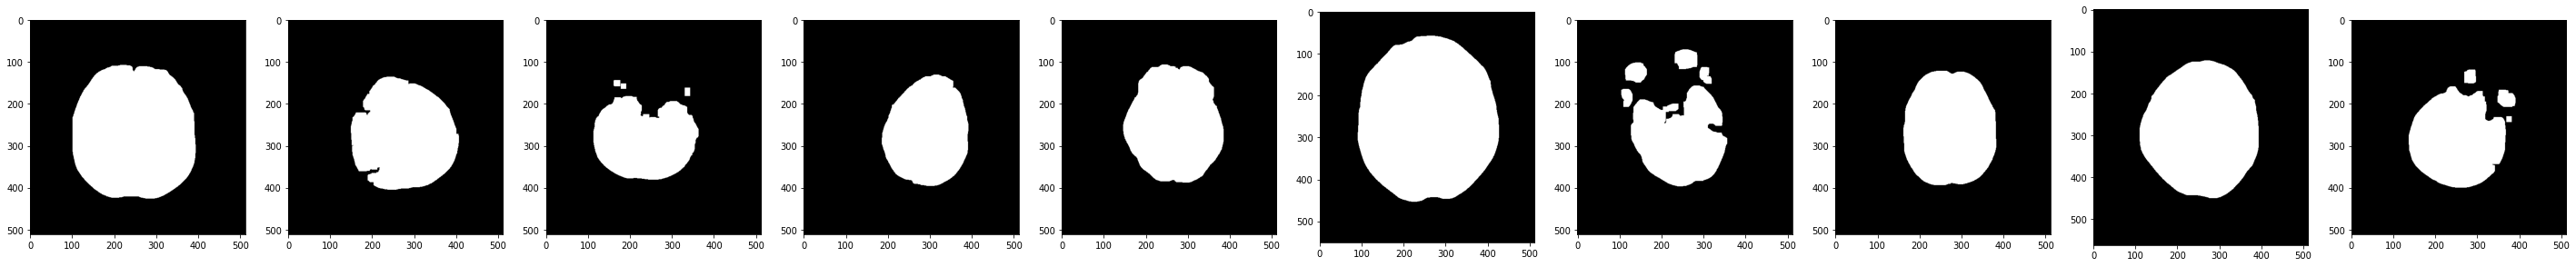

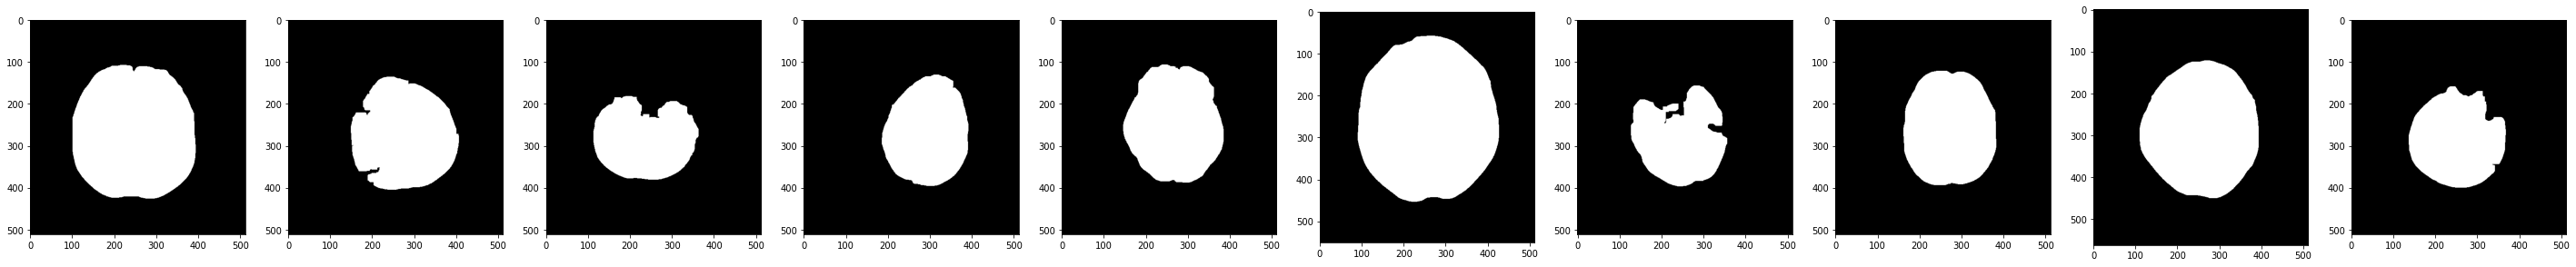

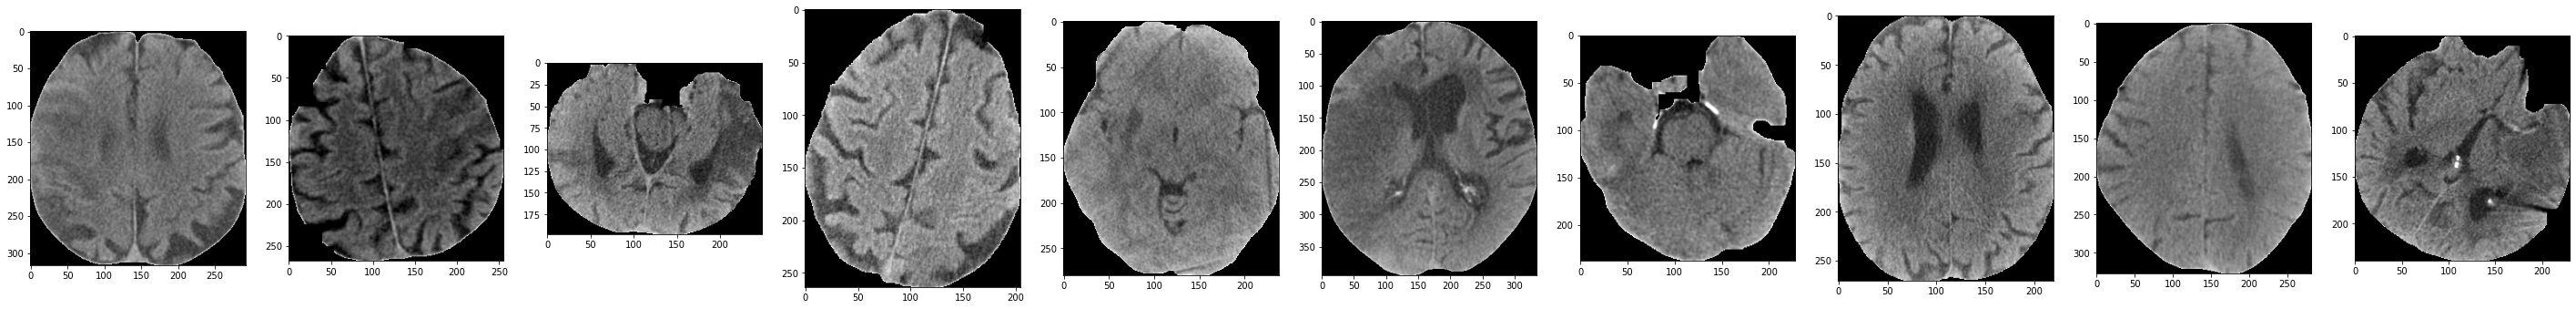

In [11]:
iskemi_set_labeled = image_process(iskemi_images, 1)

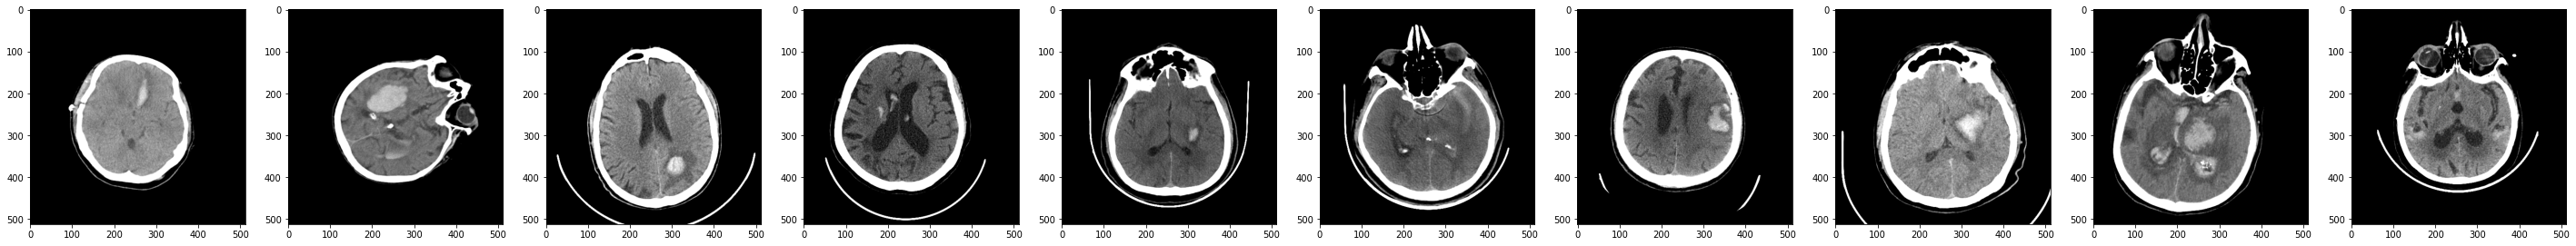

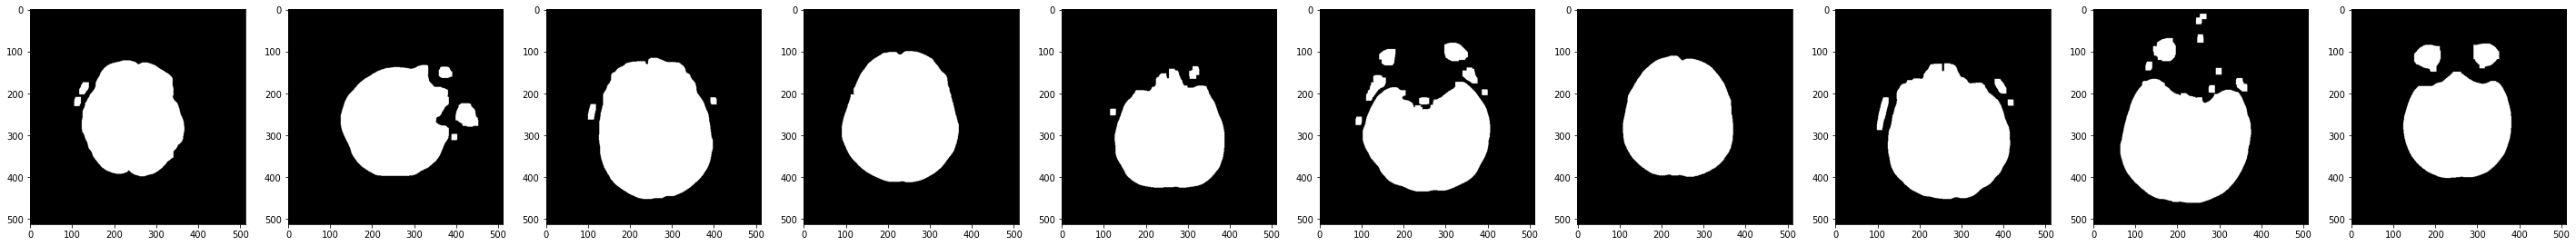

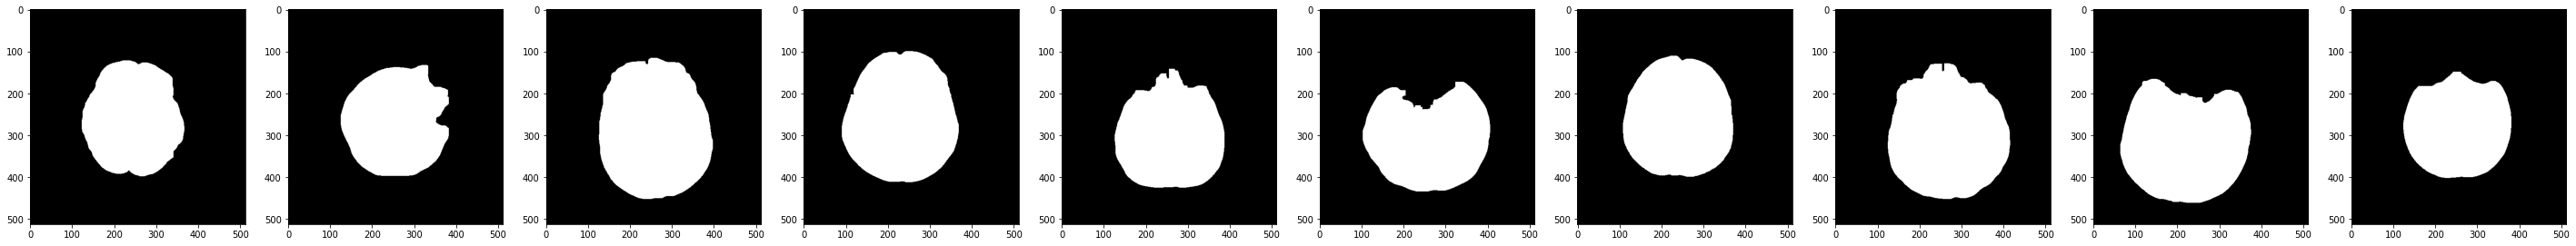

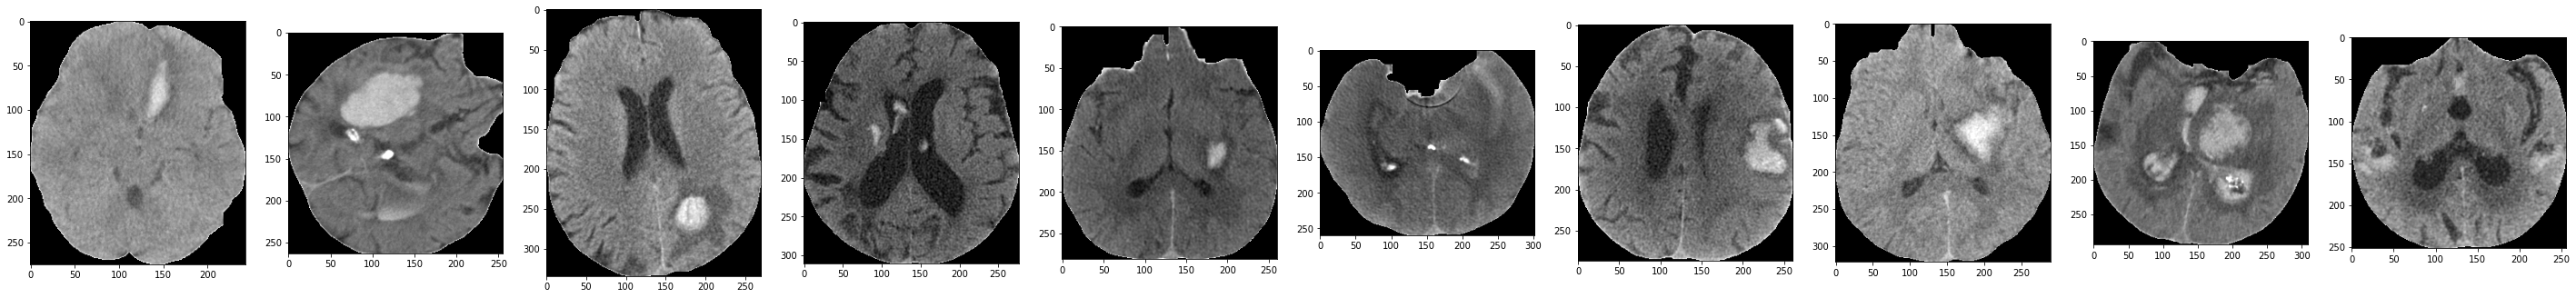

In [12]:
kanama_set_labeled = image_process(kanama_images, 2)

In [30]:
label = ['Non-Stroke', 'Ischemia', 'Hemorrhage']

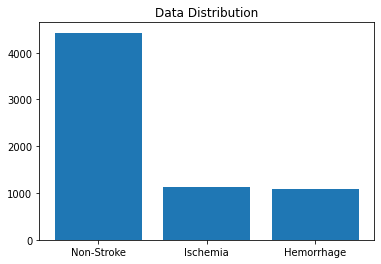

In [14]:
plt.bar(label, [len(inmeyok_set_labeled), len(iskemi_set_labeled), len(kanama_set_labeled)])
plt.title('Data Distribution')
plt.show()

In [15]:
dataset = [*inmeyok_set_labeled, *iskemi_set_labeled, *kanama_set_labeled]

In [16]:
X = [i[0] for i in dataset]
y = [i[1] for i in dataset]

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=99, shuffle=True)

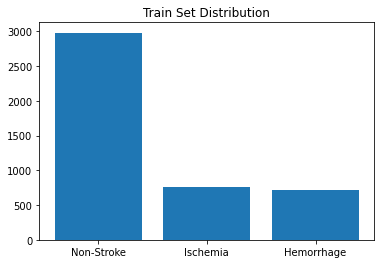

In [18]:
plt.bar(label, [y_train.count(0), y_train.count(1), y_train.count(2)])
plt.title('Train Set Distribution')
plt.show()

In [19]:
# Horizontal flip
X_train = [*X_train, *[cv2.flip(X_train[i], 1) for i in list(np.where(np.asarray(y_train) == 1)[0])]]
y_train = [*y_train, *[1]*y_train.count(1)]

X_train = [*X_train, *[cv2.flip(X_train[i], 1) for i in list(np.where(np.asarray(y_train) == 2)[0])]]
y_train = [*y_train, *[2]*y_train.count(2)]

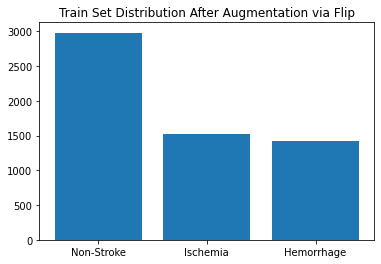

In [20]:
plt.bar(label, [y_train.count(0), y_train.count(1), y_train.count(2)])
plt.title('Train Set Distribution After Augmentation via Flip')
plt.show()

In [21]:
# Rotation
X_train = [*X_train, *[rotate(X_train[i], 30, reshape=False) for i in list(np.where(np.asarray(y_train) == 1)[0])]]
y_train = [*y_train, *[1]*y_train.count(1)]

X_train = [*X_train, *[rotate(X_train[i], 30, reshape=False) for i in list(np.where(np.asarray(y_train) == 2)[0])]]
y_train = [*y_train, *[2]*y_train.count(2)]

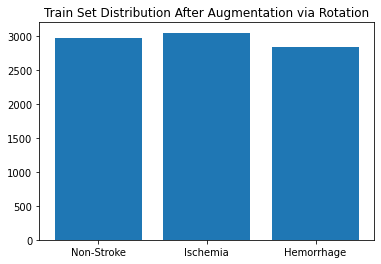

In [22]:
plt.bar(label, [y_train.count(0), y_train.count(1), y_train.count(2)])
plt.title('Train Set Distribution After Augmentation via Rotation')
plt.show()

In [45]:
pickle.dump(X_train, open('X_train.pkl', 'wb'))
pickle.dump(y_train, open('y_train.pkl', 'wb'))
pickle.dump(X_test, open('X_test.pkl', 'wb'))
pickle.dump(y_test, open('y_test.pkl', 'wb'))